In [9]:
# Alperen
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split

# Reading train and test CSV files
train_df = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/train.csv')
test_df = pd.read_csv('/Users/ad53533/Desktop/Applied ML/Project/test.csv')

# Drop data that doesn't even have sii
train_df = train_df.dropna(subset=['sii'])

# Drop columns that contain 'PCIAT', because this is not in test dataset
train_df = train_df[train_df.columns.drop(list(train_df.filter(regex='PCIAT')))]

# categorical variables to val
label_encoders = {}
for column in train_df.columns:
    if train_df[column].dtype == 'object':
        le = LabelEncoder()
        train_df[column] = le.fit_transform(train_df[column].astype(str))
        label_encoders[column] = le

X = train_df.drop(['id','sii'], axis=1)
y = train_df['sii']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45, stratify=y)
# Reset the indices of the training and testing sets
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [45]:
# Assuming your data frames are df1 and df2

# Get the columns in each data frame
columns_df1 = set(train_df.columns)
columns_df2 = set(test_df.columns)

# Find columns that are only in df1
unique_to_df1 = columns_df1 - columns_df2

# Find columns that are only in df2
unique_to_df2 = columns_df2 - columns_df1

# Find columns common to both
common_columns = columns_df1 & columns_df2

# Display the results
print("Columns unique to df1:", unique_to_df1)
print("Columns unique to df2:", unique_to_df2)
print("Common columns:", common_columns)


Columns unique to df1: set()
Columns unique to df2: set()
Common columns: {'BIA-BIA_FMI', 'PAQ_C-Season_Summer', 'Fitness_Endurance-Season_Summer', 'PAQ_C-Season_Winter', 'Physical-Systolic_BP', 'Basic_Demos-Enroll_Season_Spring', 'Fitness_Endurance-Max_Stage', 'FGC-Season_Winter', 'PreInt_EduHx-computerinternet_hoursday', 'FGC-Season_Summer', 'BIA-BIA_Fat', 'FGC-FGC_GSND', 'BIA-BIA_LDM', 'CGAS-CGAS_Score', 'Physical-Weight', 'PAQ_C-Season_Spring', 'FGC-FGC_TL_Zone', 'PreInt_EduHx-Season_Spring', 'PAQ_A-Season_Winter', 'Fitness_Endurance-Season_Winter', 'FGC-FGC_TL', 'FGC-FGC_SRR_Zone', 'SDS-SDS_Total_Raw', 'Physical-Diastolic_BP', 'FGC-FGC_CU', 'PreInt_EduHx-Season_Summer', 'CGAS-Season_Spring', 'Physical-Season_Winter', 'FGC-FGC_SRR', 'Physical-HeartRate', 'Physical-Season_Spring', 'BIA-Season_Summer', 'Fitness_Endurance-Season_Spring', 'FGC-Season_Spring', 'BIA-BIA_LST', 'BIA-BIA_Frame_num', 'BIA-BIA_FFM', 'FGC-FGC_SRL_Zone', 'FGC-FGC_GSD', 'Physical-Season_Summer', 'BIA-Season_Wint

Best parameters found:  {'alpha': 10}
Mean Squared Error: 1.1204379562043796
Mean Absolute Error: 0.6897810218978102
Accuracy: 0.4908759124087591
Quadratic Weighted Kappa: 0.365527853099461


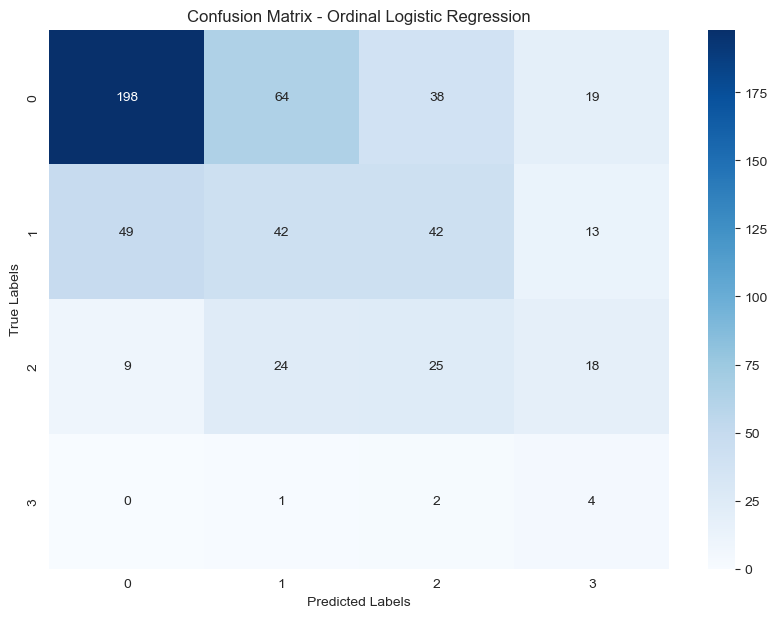

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, cohen_kappa_score
from imblearn.over_sampling import SMOTE
from mord import LogisticIT  # Ordinal Logistic Regression (LogisticIT model)

# 1. Impute missing values in the training data
knn_imputer = KNNImputer(n_neighbors=3)
X_train_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# Add the target column (sii) to the imputed training data for correlation calculation
X_train_imputed_2 = X_train_imputed.copy()
X_train_imputed_2['sii'] = y_train

# Calculate the correlation matrix
correlation_matrix = X_train_imputed_2.corr()

# Get the correlation of all features with 'sii'
sii_correlation = correlation_matrix['sii'].drop('sii')  # Exclude self-correlation

# Find the most correlated feature with 'sii'
most_correlated_feature = sii_correlation.abs().idxmax()
most_correlated_value = sii_correlation[most_correlated_feature]

# Select the top 20 most correlated features with 'sii'
top__features = sii_correlation.abs().sort_values(ascending=False).head(80)
# Get the names of the top 20 most correlated features
top__feature_names = top__features.index

# Filter X_train and X_test to keep only the top 20 most correlated features
X_train_imputed = X_train_imputed[top__feature_names].copy()


# 2. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# 3. Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# 4. Define the Ordinal Logistic Regression model
model = LogisticIT()

# 5. Set up StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6. Define a parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 10, 100, 1000]  # Regularization parameter for LogisticIT
}

# Convert labels to integer type
y_train_balanced = y_train_balanced.astype(int)
y_test = y_test.astype(int)

# 7. Grid search with StratifiedKFold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train_balanced, y_train_balanced)

# 8. Best parameters and model fitting
print("Best parameters found: ", grid_search.best_params_)
model = grid_search.best_estimator_

# 9. Impute missing values and standardize the test data
X_test_imputed = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns)
X_test_imputed = X_test_imputed[top__feature_names].copy()
X_test_scaled = scaler.transform(X_test_imputed)

# 10. Predicting on the test set
y_pred = model.predict(X_test_scaled)

# 11. Model evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Accuracy: {accuracy}')
print(f'Quadratic Weighted Kappa: {kappa}')

# 12. Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix - Ordinal Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

/var/folders/kf/59lqk6h51mj0n58qklnhrm580000gq/T/ipykernel_21372/3298220051.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_transformed[f'{col}_cubed'] = X_train_imputed[col] ** 3
/var/folders/kf/59lqk6h51mj0n58qklnhrm580000gq/T/ipykernel_21372/3298220051.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_transformed[f'{col}_squared'] = X_train_imputed[col] ** 2
/var/folders/kf/59lqk6h51mj0n58qklnhrm580000gq/T/ipykernel_21372/3298220051.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is us

Best parameters found:  {'alpha': 1}
Mean Squared Error: 1.051094890510949
Mean Absolute Error: 0.6496350364963503
Accuracy: 0.5218978102189781
Quadratic Weighted Kappa: 0.42962877298485025


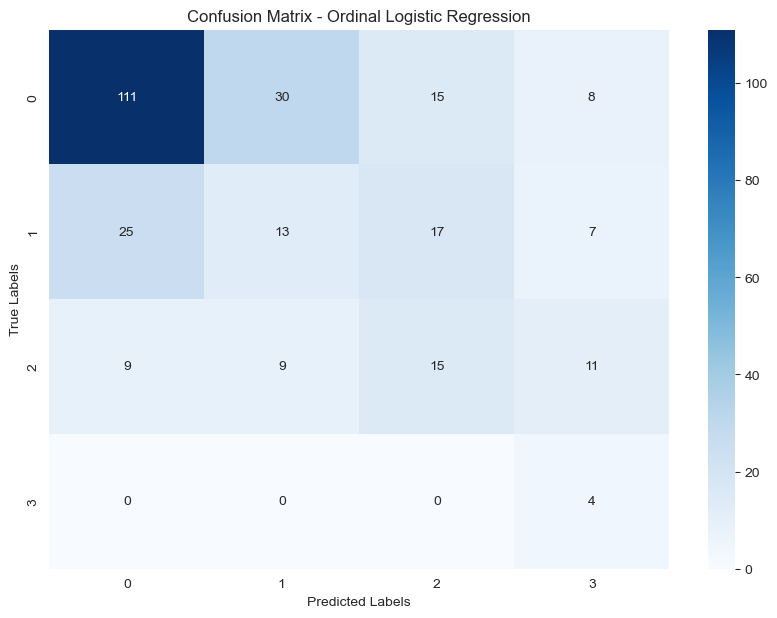

In [54]:
# Alperen: Using Hormoz's implementation to select top correlated features with different functions: (.)^2, (.)^3, ln(.).
# Goes up to 0.454
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, cohen_kappa_score
from imblearn.over_sampling import SMOTE
from mord import LogisticIT  # Ordinal Logistic Regression (LogisticIT model)

# 1. Impute missing values in the training data
knn_imputer = KNNImputer(n_neighbors=3)
X_train_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# Create transformed versions of the features
X_train_transformed = X_train_imputed.copy()

# Apply ln, squared, and cubed transformations only to features, not 'sii'
for col in X_train_imputed.columns:
    if col != 'sii':  # Ensure 'sii' is not included in transformations
        if (X_train_imputed[col] > 0).all():  # Ensure no negative or zero values for ln
            X_train_transformed[f'ln_{col}'] = np.log(X_train_imputed[col])
        X_train_transformed[f'{col}_squared'] = X_train_imputed[col] ** 2
        X_train_transformed[f'{col}_cubed'] = X_train_imputed[col] ** 3

# Add the target column (sii) for correlation calculation (without transforming it)
X_train_transformed['sii'] = y_train

# Calculate the correlation matrix
correlation_matrix_transformed = X_train_transformed.corr()

# Get the correlation of all features (original and transformed) with 'sii'
sii_correlation_transformed = correlation_matrix_transformed['sii'].drop('sii')  # Exclude self-correlation

# Select the top 30 most correlated features (original and transformed)
top_30_features = sii_correlation_transformed.abs().sort_values(ascending=False).head(50)
top_30_feature_names = top_30_features.index

# Filter X_train_imputed and X_test_imputed to keep only the top 30 features
X_train_top_30 = X_train_transformed[top_30_feature_names].copy()
X_test_imputed = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns)

# Apply the same transformations to X_test_imputed
X_test_transformed = X_test_imputed.copy()
for col in X_test_imputed.columns:
    if col != 'sii':  # Ensure 'sii' is not included in transformations
        if (X_test_imputed[col] > 0).all():  # Ensure no negative or zero values for ln
            X_test_transformed[f'ln_{col}'] = np.log(X_test_imputed[col])
        X_test_transformed[f'{col}_squared'] = X_test_imputed[col] ** 2
        X_test_transformed[f'{col}_cubed'] = X_test_imputed[col] ** 3

# Filter X_test_transformed to keep only the top 30 features
X_test_top_30 = X_test_transformed[top_30_feature_names].copy()

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top_30)
X_test_scaled = scaler.transform(X_test_top_30)

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Define the Ordinal Logistic Regression model
model = LogisticIT()

# Set up StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 10, 100, 1000]  # Regularization parameter for LogisticIT
}

# Convert labels to integer type
y_train_balanced = y_train_balanced.astype(int)
y_test = y_test.astype(int)

# Grid search with StratifiedKFold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and model fitting
print("Best parameters found: ", grid_search.best_params_)
model = grid_search.best_estimator_

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Accuracy: {accuracy}')
print(f'Quadratic Weighted Kappa: {kappa}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix - Ordinal Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

/var/folders/kf/59lqk6h51mj0n58qklnhrm580000gq/T/ipykernel_21372/2338330721.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_transformed[f'{col}_cubed'] = X_train_imputed[col] ** 3
/var/folders/kf/59lqk6h51mj0n58qklnhrm580000gq/T/ipykernel_21372/2338330721.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_transformed[f'{col}_fourth'] = X_train_imputed[col] ** 4
/var/folders/kf/59lqk6h51mj0n58qklnhrm580000gq/T/ipykernel_21372/2338330721.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usu

Best parameters found:  {'alpha': 1}
Mean Squared Error: 0.9854014598540146
Mean Absolute Error: 0.6240875912408759
Accuracy: 0.5383211678832117
Quadratic Weighted Kappa: 0.4275057264904353


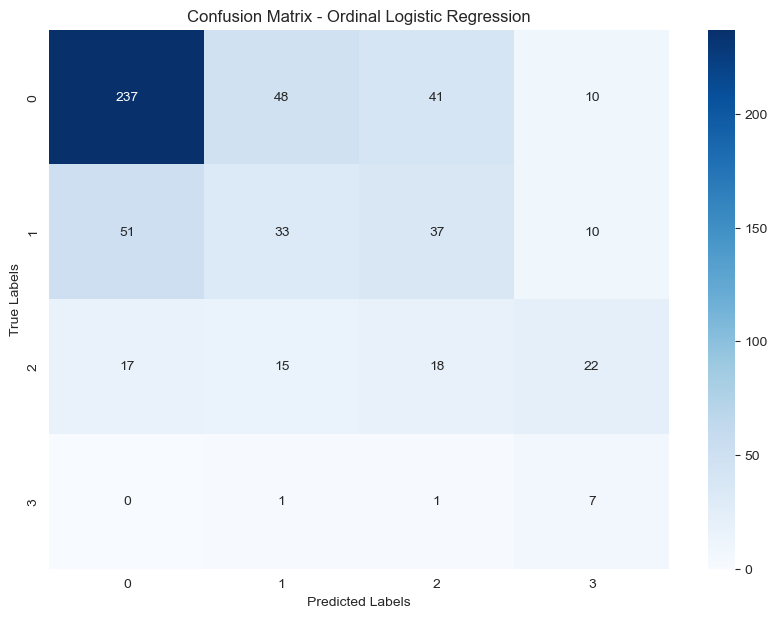

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, cohen_kappa_score
from imblearn.over_sampling import SMOTE
from mord import LogisticIT  # Ordinal Logistic Regression (LogisticIT model)

# Step 1: Impute missing values in the training data
knn_imputer = KNNImputer(n_neighbors=3)
X_train_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# Step 2: Create transformed versions of the features without including 'sii'
X_train_transformed = X_train_imputed.copy()

# Apply various transformations for feature analysis
for col in X_train_imputed.columns:
    if col != 'sii':  # Ensure 'sii' is not included in transformations
        if (X_train_imputed[col] > 0).all():  # Ensure no negative or zero values for ln
            X_train_transformed[f'ln_{col}'] = np.log(X_train_imputed[col])
            X_train_transformed[f'sqrt_{col}'] = np.sqrt(X_train_imputed[col])
            X_train_transformed[f'reciprocal_{col}'] = 1 / X_train_imputed[col]
        
        # Apply functions that don't require positive values
        X_train_transformed[f'{col}_squared'] = X_train_imputed[col] ** 2
        X_train_transformed[f'{col}_cubed'] = X_train_imputed[col] ** 3
        X_train_transformed[f'{col}_fourth'] = X_train_imputed[col] ** 4
        X_train_transformed[f'exp_{col}'] = np.exp(X_train_imputed[col])
        
        # Apply trigonometric functions (useful for cyclic features)
        X_train_transformed[f'sin_{col}'] = np.sin(X_train_imputed[col])
        X_train_transformed[f'cos_{col}'] = np.cos(X_train_imputed[col])
        X_train_transformed[f'tan_{col}'] = np.tan(X_train_imputed[col])

# Step 3: Add the target column (sii) for correlation calculation (without transforming it)
X_train_transformed['sii'] = y_train

# Step 4: Calculate the correlation matrix
correlation_matrix_transformed = X_train_transformed.corr()

# Step 5: Get the correlation of all features (original and transformed) with 'sii'
sii_correlation_transformed = correlation_matrix_transformed['sii'].drop('sii')  # Exclude self-correlation

# Step 6: Select the top 50 most correlated features (original and transformed)
top_50_features = sii_correlation_transformed.abs().sort_values(ascending=False).head(100)

# # Print the top 50 most correlated features and their correlation values
# print("Top 50 most correlated features (original and transformed) with 'sii':")
# print(top_50_features)

# Get the names of the top 50 most correlated features
top_50_feature_names = top_50_features.index

# Step 7: Filter X_train_imputed and X_test_imputed to keep only the top 50 features
X_train_top_50 = X_train_transformed[top_50_feature_names].copy()
X_test_imputed = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns)

# Apply the same transformations to X_test_imputed
X_test_transformed = X_test_imputed.copy()
for col in X_test_imputed.columns:
    if col != 'sii':  # Ensure 'sii' is not included in transformations
        if (X_test_imputed[col] > 0).all():  # Ensure no negative or zero values for ln
            X_test_transformed[f'ln_{col}'] = np.log(X_test_imputed[col])
            X_test_transformed[f'sqrt_{col}'] = np.sqrt(X_test_imputed[col])
            X_test_transformed[f'reciprocal_{col}'] = 1 / X_test_imputed[col]
        
        # Apply functions that don't require positive values
        X_test_transformed[f'{col}_squared'] = X_test_imputed[col] ** 2
        X_test_transformed[f'{col}_cubed'] = X_test_imputed[col] ** 3
        X_test_transformed[f'{col}_fourth'] = X_test_imputed[col] ** 4
        X_test_transformed[f'exp_{col}'] = np.exp(X_test_imputed[col])
        
        # Apply trigonometric functions
        X_test_transformed[f'sin_{col}'] = np.sin(X_test_imputed[col])
        X_test_transformed[f'cos_{col}'] = np.cos(X_test_imputed[col])
        X_test_transformed[f'tan_{col}'] = np.tan(X_test_imputed[col])

# Step 8: Filter X_test_transformed to keep only the top 50 features
X_test_top_50 = X_test_transformed[top_50_feature_names].copy()

# Step 9: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top_50)
X_test_scaled = scaler.transform(X_test_top_50)

# Step 10: Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Step 11: Define the Ordinal Logistic Regression model
model = LogisticIT()

# Step 12: Set up StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 13: Define a parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 10, 100, 1000]  # Regularization parameter for LogisticIT
}

# Step 14: Convert labels to integer type
y_train_balanced = y_train_balanced.astype(int)
y_test = y_test.astype(int)

# Step 15: Grid search with StratifiedKFold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train_balanced, y_train_balanced)

# Step 16: Best parameters and model fitting
print("Best parameters found: ", grid_search.best_params_)
model = grid_search.best_estimator_

# Step 17: Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Step 18: Model evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Accuracy: {accuracy}')
print(f'Quadratic Weighted Kappa: {kappa}')

# Step 19: Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 20: Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix - Ordinal Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Best parameters found:  {'alpha': 10}
Mean Squared Error: 1.0036496350364963
Mean Absolute Error: 0.6240875912408759
Accuracy: 0.5456204379562044
Quadratic Weighted Kappa: 0.42240176613978875


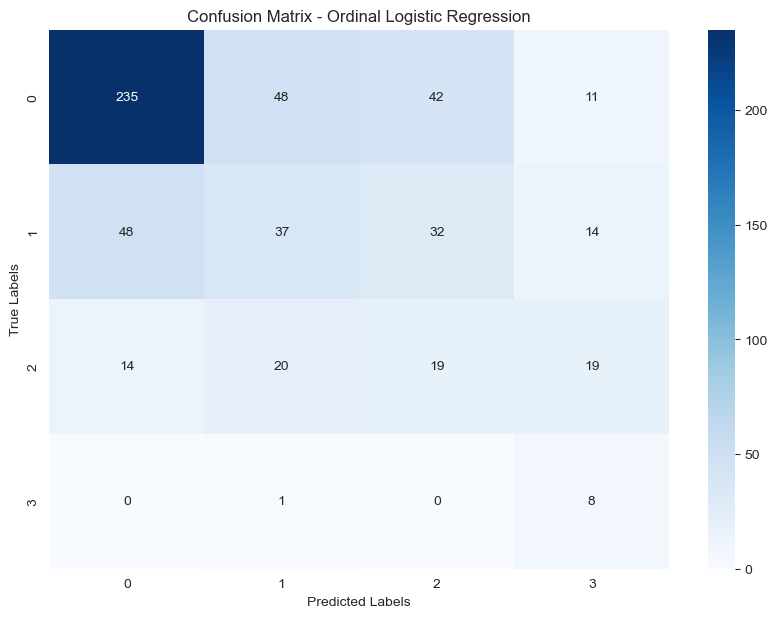

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, cohen_kappa_score
from imblearn.over_sampling import SMOTE
from mord import LogisticIT  # Ordinal Logistic Regression (LogisticIT model)

# 1. Impute missing values in the training data
knn_imputer = KNNImputer(n_neighbors=3)
X_train_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)

# Calculate the correlation matrix for the imputed training data
correlation_matrix = X_train_imputed.corr()

# Set a threshold for high correlation (e.g., |correlation| > 0.8)
threshold = 0.99

# Extract the upper triangle of the correlation matrix to avoid duplicate pairs
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find index pairs where the correlation is above the threshold
correlated_pairs = [(col, row) for col in upper_triangle.columns for row in upper_triangle.index if abs(upper_triangle.loc[row, col]) > threshold]

# Set to keep track of features to drop
features_to_drop = set()

# Iterate over the correlated pairs and add one feature to the drop list
for feature1, feature2 in correlated_pairs:
    # You can customize this logic, e.g., based on correlation with 'sii'
    if feature1 not in features_to_drop and feature2 not in features_to_drop:
        # Add the second feature to the drop list (or use other criteria)
        features_to_drop.add(feature2)

# Drop the selected features from X_train_imputed
X_train_imputed_reduced = X_train_imputed.drop(columns=list(features_to_drop))

# 2. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed_reduced)

# 3. Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# 4. Define the Ordinal Logistic Regression model
model = LogisticIT()

# 5. Set up StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6. Define a parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 10, 100, 1000]  # Regularization parameter for LogisticIT
}

# Convert labels to integer type
y_train_balanced = y_train_balanced.astype(int)
y_test = y_test.astype(int)

# 7. Grid search with StratifiedKFold
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train_balanced, y_train_balanced)

# 8. Best parameters and model fitting
print("Best parameters found: ", grid_search.best_params_)
model = grid_search.best_estimator_

# 9. Impute missing values and standardize the test data
X_test_imputed = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns)
X_test_imputed = X_test_imputed.drop(columns=list(features_to_drop))
X_test_scaled = scaler.transform(X_test_imputed)

# 10. Predicting on the test set
y_pred = model.predict(X_test_scaled)

# 11. Model evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Accuracy: {accuracy}')
print(f'Quadratic Weighted Kappa: {kappa}')

# 12. Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title('Confusion Matrix - Ordinal Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
